## Stars classification.

Possible values:
1. **1** star
2. **2** stars
3. **3** stars
4. **4** stars
5. **5** stars

In [1]:
from transformers import pipeline # To create classifier
import pandas as pd # To read data
import tensorflow as tf # To create model
from tqdm.auto import tqdm # To show progress
from torch.utils.data import Dataset # To create dataset
import torch # To create model
import matplotlib.pyplot as plt # To plot
import numpy as np # To perform calculations

In [2]:
# Load the model
classifier = pipeline("text-classification",
                    model = "nlptown/bert-base-multilingual-uncased-sentiment",
                    device = 0, framework = "pt")

In [3]:
# Example in spanish
text = "Te odio un poco"

classifier(text)

[{'label': '3 stars', 'score': 0.3536396622657776}]

In [4]:
# Load whole dataset
test_set = pd.read_excel("data/train_sentiment_analysis.xlsx")

print(len(test_set))
test_set.head(3)

30212


,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1.0,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1.0,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1.0,Hotel


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\missa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\missa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
def removeStopwords( texto):
    blob = TextBlob(texto).words
    outputlist = [word for word in blob if word not in stopwords.words('spanish')]
    return(' '.join(word for word in outputlist))

In [7]:
# Save review word count
n_words = []

for id in tqdm(test_set.index):
    # Merge Title and Opinion
    test_set.at[id, 'Opinion'] = str(test_set.at[id, 'Title']) \
        + ". " + str(test_set.at[id, 'Opinion'])
    # opinion = removeStopwords(test_set.at[id, 'Opinion'])
    opinion = test_set.at[id, 'Opinion']
    test_set.at[id, 'Opinion'] = opinion
    n_words.append(len(opinion.split()))

    # Truncate to max length of 280 words
    if len(opinion.split()) > 280:
        test_set.at[id, 'Opinion'] = ' '.join(opinion.split()[:280])

# Remove Title column
test_set.drop(columns=['Title'], inplace=True)

100%|██████████| 30212/30212 [00:01<00:00, 25412.48it/s]


In [8]:
print(len([word for word in n_words if word > 280])) # Words that are too long
print(len([word for word in n_words if word < 280]))

2457
27747


In [9]:
# New dataset structure
test_set.head(5)

,Opinion,Polarity,Attraction
0,Pésimo lugar. Piensen dos veces antes de ir a ...,1.0,Hotel
1,No vayas a lugar de Eddie. Cuatro de nosotros ...,1.0,Restaurant
2,Mala relación calidad-precio. seguiré corta y ...,1.0,Hotel
3,Minusválido? ¡No te alojes aquí!. Al reservar ...,1.0,Hotel
4,Es una porqueria no pierdan su tiempo. No pier...,1.0,Hotel


In [10]:
# True labels
x = list(test_set['Polarity'])

# Text to predict from
data = list(test_set['Opinion'])

In [11]:
# Create dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

dataset = MyDataset(data)

In [29]:
# Predict and show progress bar
y = []
for out in tqdm(classifier(dataset, batch_size = 64), total=len(dataset)):
    y.append(out)

100%|██████████| 30212/30212 [06:28<00:00, 77.67it/s] 


In [30]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [31]:
# Free gpu memory
torch.cuda.empty_cache()

# Print example
y[100]['label']

'2 stars'

In [15]:
# Label to integer
stars2num = {'1 star': 1, '2 stars': 2, '3 stars': 3,
             '4 stars': 4, '5 stars': 5}

# Predictions
y_hat = []
for pred in y:
    y_hat.append(stars2num[pred['label']])

In [16]:
# Mean absolute error
def get_mae(y, y_hat):
    return sum(abs(y - y_hat)) / len(y)

# Accuracy
def get_accuracy(y, y_hat):
    return sum([1 if y[i] == y_hat[i] else 0 for i in range(len(y))]) / len(y)

mae = get_mae(np.array(x), np.array(y_hat))
acc = get_accuracy(np.array(x), np.array(y_hat))

In [18]:
# Without nltk
print(f'MAE: {mae:.3f}')
print(f'MAE contribution: {(1/(1+mae))/2:.3f}')
print(f'Accuracy: {acc:.3f}')

MAE: 0.321
MAE contribution: 0.379
Accuracy: 0.730


In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

cm = confusion_matrix(x, y_hat)

Text(0.5, 1.0, 'Confusion matrix')

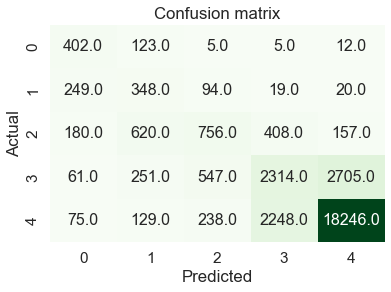

In [20]:
df = pd.DataFrame(cm)

sns.set(font_scale=1.4)
sns.heatmap(df, annot=True, annot_kws={"size": 16},
            cmap="Greens", fmt='.1f',
            cbar_kws={'label': 'ln(count)'}, cbar = False)

# Colorbar
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

Text(0.5, 1.0, 'Confusion matrix')

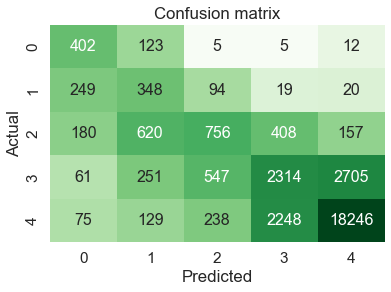

In [22]:
# Without nltk
df = pd.DataFrame(cm)

sns.set(font_scale=1.4)
sns.heatmap(df, annot=True, annot_kws={"size": 16},
            cmap="Greens", fmt='g', cbar_kws={'label': 'Count'},
            norm = LogNorm(), cbar = False)

# Colorbar
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

## Atraction classification.

Possible values:
1. Hotel.
2. Restaurant.
3. Atractive.

In [6]:
# Delete past classifier
# del classifier, dataset

# Load new model (zero-shot)
classifier = pipeline("zero-shot-classification",
                    model = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
                    device = 0, framework = "pt")

In [7]:
for label in test_set['Attraction'].unique():
    print(f'Lale: {label}. Count: {test_set[test_set["Attraction"] == label].shape[0]}')

Lale: Hotel. Count: 16565
Lale: Restaurant. Count: 8450
Lale: Attractive. Count: 5197


In [8]:
test_set[test_set["Attraction"] == 'Attractive'].head(5)

,Opinion,Polarity,Attraction
467,"¡Momias, demasiado impresionante!. Las momias ...",1.0,Attractive
468,Comida cara. Tienen carteles con comida cortid...,1.0,Attractive
469,"No coman ahí. Creo que es muy insalubre, hay b...",1.0,Attractive
470,Momificado. Para mí gusto no vale la pena... t...,1.0,Attractive
471,Incómodo y cero romántico. Es un lugar poco in...,1.0,Attractive


    -    Nota: Creo que los atractivos con la etiqueta de "Atractive" vienen del dataset del año pasado.

In [9]:
# Rename Attractive -> Tourist attraction
test_set.loc[test_set["Attraction"] == 'Attractive', "Attraction"] = 'Tourist attraction'

In [13]:
test_set[test_set["Attraction"] == 'Tourist attraction'].head(3)

,Opinion,Polarity,Attraction
467,"¡Momias, demasiado impresionante!. Las momias ...",1.0,Tourist attraction
468,Comida cara. Tienen carteles con comida cortid...,1.0,Tourist attraction
469,"No coman ahí. Creo que es muy insalubre, hay b...",1.0,Tourist attraction


In [14]:
# Example
labels = ['Hotel', 'Restaurant', 'Tourist attraction']
test = 'Las sabanas estaban sucias, pero las habitaciones estaban muy bien'

classifier(test, candidate_labels = labels)

{'sequence': 'Las sabanas estaban sucias, pero las habitaciones estaban muy bien',
 'labels': ['Hotel', 'Tourist attraction', 'Restaurant'],
 'scores': [0.8496659398078918, 0.12080366164445877, 0.029530402272939682]}

In [15]:
# True labels
x = list(test_set['Attraction'])

# Text to predict from
data = list(test_set['Opinion'])

In [16]:
# Create dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

dataset = MyDataset(data)

In [17]:
# Predict and show progress bar
y = []
for out in tqdm(classifier(dataset,
                batch_size = 32,
                candidate_labels = labels), total=len(dataset)):
    y.append(out)

100%|██████████| 30212/30212 [42:16<00:00, 11.91it/s]


In [27]:
# Free gpu memory
torch.cuda.empty_cache()

# Print example
y[0:5]

[{'sequence': 'Pésimo lugar. Piensen dos veces antes de ir a este hotel, te molestan por todo, mi hijo de seis años traía un inflable de tamaño pequeño y nos decían que era muy grande ahí lo veían llorando y aún así seguían molestando, traíamos una hielera que parece bolsa nada de grande o con ruedas o de ese estilo y Tmb molestándonos las bebidas carísimas y ni agua te dejan tener en la alberca y no hay ni huéspedes en el hotel esto es en el mayan palace el grand mayan pude ser un poco mejor pero la verdad jamás vuelvo a venir a este lugar, te invitan a una cena show de mil pesos por persona y la cena es hoy dogs, las habitaciones nada fuera de lo normal',
  'labels': ['Tourist attraction', 'Hotel', 'Restaurant'],
  'scores': [0.565515398979187, 0.24745117127895355, 0.18703341484069824]},
 {'sequence': "No vayas a lugar de Eddie. Cuatro de nosotros fuimos recientemente a Eddie's Place. El servicio era terrible a pesar del hecho de que Eddie y personalmente vino a nuestra mesa con su c

In [28]:
y_pred = []
scores = []

for pred in y:
    y_pred.append(pred['labels'])
    scores.append(pred['scores'])

In [29]:
test_set['Predicted'] = y_pred
test_set['Scores'] = scores

test_set.head(3)

,Opinion,Polarity,Attraction,Predicted,Scores
0,Pésimo lugar. Piensen dos veces antes de ir a ...,1.0,Hotel,"[Tourist attraction, Hotel, Restaurant]","[0.565515398979187, 0.24745117127895355, 0.187..."
1,No vayas a lugar de Eddie. Cuatro de nosotros ...,1.0,Restaurant,"[Restaurant, Tourist attraction, Hotel]","[0.8265421390533447, 0.09087672829627991, 0.08..."
2,Mala relación calidad-precio. seguiré corta y ...,1.0,Hotel,"[Restaurant, Hotel, Tourist attraction]","[0.9911404252052307, 0.008396192453801632, 0.0..."


In [31]:
# Save results
# test_set.to_csv('results/predict_attractive_results_newLabel.csv')

In [32]:
y_hat = []
for pred in y:
    y_hat.append(pred['labels'][0])

In [33]:
accuracy = 0

for i in range(len(y_hat)):
    if y_hat[i] == x[i]:
        accuracy += 1

accuracy /= len(y_hat)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.718


In [34]:
def get_fscore(y, y_hat, label):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(y)):
        if y[i] == label:
            if y_hat[i] == label:
                tp += 1
            else:
                fn += 1
        else:
            if y_hat[i] == label:
                fp += 1
    f1 = tp/(tp+(fp+fn)/2)
    return f1

def macro_f(y, y_hat):
    f1_attractive = get_fscore(y, y_hat, 'Tourist attraction')
    f1_hotel = get_fscore(y, y_hat, 'Hotel')
    f1_restaurant = get_fscore(y, y_hat, 'Restaurant')

    print(f'Tourist attraction F1: {f1_attractive:.3f}')
    print(f'Hotel F1: {f1_hotel:.3f}')
    print(f'Restaurant F1: {f1_restaurant:.3f}')
    return (f1_attractive + f1_hotel + f1_restaurant) / 3

mf = macro_f(x, y_hat)
print(f'Macro-F: {mf:.3f}')
print(f'Macro-F contribution: {mf/2:.3f}')

Tourist attraction F1: 0.644
Hotel F1: 0.700
Restaurant F1: 0.800
Macro-F: 0.714
Macro-F contribution: 0.357


In [35]:
label2num = {'Tourist attraction': 0, 'Hotel': 1, 'Restaurant': 2}
x_num = [label2num[i] for i in x]
y_hat_num = [label2num[i] for i in y_hat]

In [36]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

cm = confusion_matrix(y_true= x_num,y_pred = y_hat_num)

Text(0.5, 1.0, 'Confusion matrix')

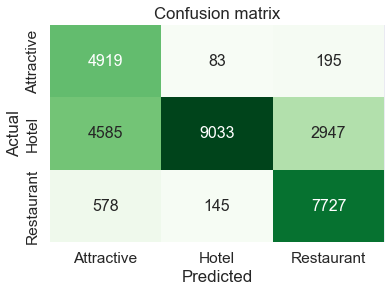

In [37]:
df = pd.DataFrame(cm)

sns.set(font_scale=1.4)
sns.heatmap(df, annot=True, annot_kws={"size": 16},
            cmap="Greens", fmt='g',
            cbar_kws={'label': 'ln(count)'}, cbar = False)

# Colorbar
plt.xticks(ticks = [0.5, 1.5, 2.5], labels = ['Attractive', 'Hotel', 'Restaurant'])
plt.yticks(ticks = [0.5, 1.5, 2.5], labels = ['Attractive', 'Hotel', 'Restaurant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [38]:
n_attractive = sum([1 if i == 0 else 0 for i in y_hat_num])
print(f'Attractive: {n_attractive}')

Attractive: 10082


## Final results.

In [40]:
mae_contribution = 0.379
macrof_contribution = 0.357

print(f'Total score: {(mae_contribution + macrof_contribution):.3f}')

Total score: 0.736


In [9]:
for clase in test_set['Attraction'].unique():
    print(f'{clase}: {test_set[test_set["Attraction"] == clase].shape[0]}')

Hotel: 16565
Restaurant: 8450
Attractive: 5197
